# Trading Strategy for Finance using LSTMs

### Notebook Configurations and Packages

Let's execute the cell below to display information about the GPUs running on the server. First, we import several widely used modules such as NumPy for numerical calculations, pandas for data management, matplotlib for visualizations, and TensorFlow for building and training deep neural networks.

**Environment Verification**

In [184]:
!nvidia-smi

Sat Apr 20 11:17:24 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.40.04    Driver Version: 418.43       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro P5000        Off  | 00000000:03:00.0 Off |                  Off |
| 26%   37C    P8    11W / 180W |  15593MiB / 16276MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Quadro P5000        Off  | 00000000:04:00.0 Off |                  Off |
| 26%   41C    P8     7W / 180W |    115MiB / 16278MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [8]:
#imports
import h5py
import pandas as pd 
import numpy as np
import pprint as pp 
import tensorflow as tf 
from tensorflow.contrib import rnn
import math
import sklearn
import matplotlib.pyplot as plt
import warnings
from tradingcore import prepareData as prepData
from numpy.random import seed
from tensorflow import keras

In [9]:
# setting up random seed
seed(42)
tf.set_random_seed(42)
MAX_SEQUENCE_LENGTH = 32
EMBEDDING_DIM = 300

In [12]:
# print versions
import matplotlib
print("Tensorflow version:",tf.__version__)
print("Sklearn version:",sklearn.__version__)
print("Numpy version:",np.__version__)
print("Matplotlib version:",matplotlib.__version__)
print("Pandas version:",pd.__version__)
print("h5py version:",h5py.__version__)

Tensorflow version: 1.13.1
Sklearn version: 0.20.1
Numpy version: 1.16.2
Matplotlib version: 3.0.2
Pandas version: 0.23.4
h5py version: 2.8.0


#### Data Preparation

A typical DL workflow starts with data preparation because the data is not clean and ready to use most of the time. Deep neural network building and training follow the data preparation. Lastly, the trained network is validated with a dataset. 

The original data needs to be cleaned before training the network. Since cleaning the data takes significant amount of time (around 20 minutes), we have stored the cleaned data into another .h5 file. If you would like to use the original data and run the cleaning code, please set the "usePreparedData" variable to "False".

In [4]:
# insampleCutoffTimestamp variable is used to split the data in time into two pieces to create training and test set.
insampleCutoffTimestamp = 1650

# The data is prepared and stored in a seperate .h5 file.
# Load the pre-prepared data
with pd.HDFStore("../data/algo_training/trainDataPrepared.h5", 'r') as train:
    df = train.get("train")     

## TODO: Data Exploration 

Explore the shape of the given dataset. We can find that there are 1,710,756 datapoints and 111 columns for each datapoint. 

In [189]:
df.shape

(1710756, 114)

### Feature Exploration

In the 111 columns, we have:
* 1 id 
* 1 Timestamp
* 5 Derived (index 0 to 4)
* 63 Fundamental (index from 0 to 63, 'fundamental_4' is missing)
* 40 Technical (index from 0 to 44, 'technical_4','technical_8','technical_15','technical_23','technical_26' are missing)
* 1 label column named y

In [193]:
df.columns

Index(['id', 'timestamp', 'derived_0', 'derived_1', 'derived_2', 'derived_3',
       'derived_4', 'fundamental_0', 'fundamental_1', 'fundamental_2',
       ...
       'technical_43', 'technical_44', 'y', 'y_lagged', 'technical_diff',
       'krnldiff', 'delta5diff', 'krnl40', 'delta540', 'fmod29'],
      dtype='object', length=114)

In [191]:
{ i.split("_")[0] for i in df.columns }

{'delta540',
 'delta5diff',
 'derived',
 'fmod29',
 'fundamental',
 'id',
 'krnl40',
 'krnldiff',
 'technical',
 'timestamp',
 'y'}

#### Fundamental Features

In [178]:
fund = [i for i in df.columns if 'fundamental' in i] 
print(len(fund))
fund

63


['fundamental_0',
 'fundamental_1',
 'fundamental_2',
 'fundamental_3',
 'fundamental_5',
 'fundamental_6',
 'fundamental_7',
 'fundamental_8',
 'fundamental_9',
 'fundamental_10',
 'fundamental_11',
 'fundamental_12',
 'fundamental_13',
 'fundamental_14',
 'fundamental_15',
 'fundamental_16',
 'fundamental_17',
 'fundamental_18',
 'fundamental_19',
 'fundamental_20',
 'fundamental_21',
 'fundamental_22',
 'fundamental_23',
 'fundamental_24',
 'fundamental_25',
 'fundamental_26',
 'fundamental_27',
 'fundamental_28',
 'fundamental_29',
 'fundamental_30',
 'fundamental_31',
 'fundamental_32',
 'fundamental_33',
 'fundamental_34',
 'fundamental_35',
 'fundamental_36',
 'fundamental_37',
 'fundamental_38',
 'fundamental_39',
 'fundamental_40',
 'fundamental_41',
 'fundamental_42',
 'fundamental_43',
 'fundamental_44',
 'fundamental_45',
 'fundamental_46',
 'fundamental_47',
 'fundamental_48',
 'fundamental_49',
 'fundamental_50',
 'fundamental_51',
 'fundamental_52',
 'fundamental_53',
 '

#### Technical Features

In [179]:
tech = [i for i in df.columns if 'technical' in i] 
print(len(tech))
tech

37


['technical_0',
 'technical_1',
 'technical_2',
 'technical_3',
 'technical_5',
 'technical_6',
 'technical_7',
 'technical_10',
 'technical_11',
 'technical_12',
 'technical_13',
 'technical_14',
 'technical_17',
 'technical_19',
 'technical_20',
 'technical_21',
 'technical_22',
 'technical_24',
 'technical_25',
 'technical_27',
 'technical_28',
 'technical_29',
 'technical_30',
 'technical_31',
 'technical_32',
 'technical_33',
 'technical_34',
 'technical_35',
 'technical_36',
 'technical_37',
 'technical_38',
 'technical_39',
 'technical_40',
 'technical_41',
 'technical_43',
 'technical_44',
 'technical_diff']

### Target Value y

The variable to perdict is 'y'. 
y has a mean of 0.0002, a std of 0.022.

In [180]:
df['y'].describe()

count    1.710756e+06
mean     2.217509e-04
std      2.240643e-02
min     -8.609413e-02
25%     -9.561389e-03
50%     -1.570681e-04
75%      9.520990e-03
max      9.349781e-02
Name: y, dtype: float64

y has a normal distribution. y has two smaller peaks at the two ends of the distribution.

Text(0.5, 1.0, 'distribution of y value')

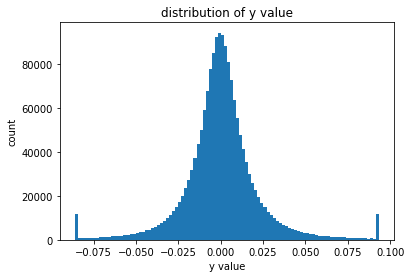

In [168]:
plt.hist(df['y'], bins=100)
plt.xlabel("y value")
plt.ylabel("count")
plt.title("distribution of y value")

#### Distribution of Y
- Mean close to zero o 
- Exist outlier

In [5]:
corr = df[df.columns[2:]].corr()['y'][:-1]
del corr['y']
corr

derived_0         0.001819
derived_1         0.000631
derived_2         0.001540
derived_3         0.000276
derived_4         0.000979
fundamental_0     0.001251
fundamental_1     0.002198
fundamental_2     0.007529
fundamental_3     0.001413
fundamental_5    -0.000432
fundamental_6    -0.000020
fundamental_7     0.005489
fundamental_8     0.004159
fundamental_9     0.001560
fundamental_10    0.000134
fundamental_11    0.006008
fundamental_12    0.000212
fundamental_13    0.002078
fundamental_14   -0.000604
fundamental_15    0.007511
fundamental_16    0.001749
fundamental_17    0.002211
fundamental_18    0.004258
fundamental_19   -0.000051
fundamental_20   -0.001384
fundamental_21    0.000053
fundamental_22   -0.000884
fundamental_23   -0.000519
fundamental_24    0.000479
fundamental_25    0.001935
                    ...   
technical_17     -0.002905
technical_19     -0.009212
technical_20     -0.015930
technical_21     -0.004598
technical_22     -0.001081
technical_24      0.001148
t

Text(0.5, 1.0, 'correlation between y and all other features')

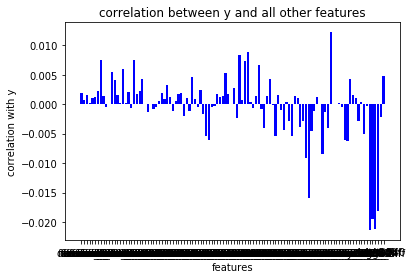

In [6]:
# plot correlation of y against all other features
plt.bar(corr.keys(), corr.values, color='b')
plt.xlabel("features")
plt.ylabel("correlation with y")
plt.title("correlation between y and all other features")

#### Correlation observation
- technical_20 has a strong positive correlation with y
- y_lagged, technical_diff, krnldiff, delta5diff have a strong negative correlation with y, which indicates that the more different the features are, the more likely that the evaluation or price that y is predicating is going to decrease.

### Plot of y trend of a specific ID against timestamps

Green plot is the cumulative y. Blue plot is the raw y.

Text(0, 0.5, 'y')

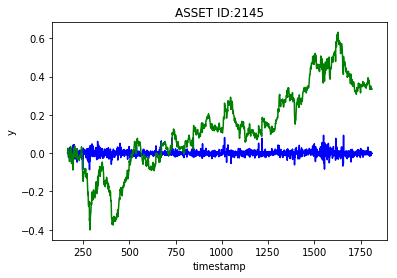

In [7]:
id_use = 2145

temp_df = df.loc[df['id']==id_use,:]
plt.plot(temp_df['timestamp'].values,temp_df['y'].values,'b')
plt.plot(temp_df['timestamp'],temp_df['y'].cumsum(),'g')
plt.title("ASSET ID:"+str(id_use))
plt.xlabel('timestamp')
plt.ylabel('y')

### Uniqueness Analysis

All combinations of id and timestamp are unique. This implies that each row represents data about each instrument at a given timestamp.

In [8]:
df.groupby(['id','timestamp']).ngroups == df.shape[0]

True

We have 1813 unique timestamps. 

In [9]:
len(df['timestamp'].unique())

1813

Dividing number of unique timestamps by 365, the result is roughly 5. If we intepret each timestamp a day in a year. We have the data of approximately 5 years.

In [131]:
len(df['timestamp'].unique())/365

4.967123287671233

We have 1424 unique instruments, which could represent portfolios. 

[**Portfolios**]: a collection of investments held by an investment company, hedge fund, financial institution or individual. 

( Staff, Investopedia (2003-11-25). "Portfolio". Investopedia. Archived from the original on 2018-04-20. Retrieved 2018-04-19.)

In [160]:
len(df.id.unique())

1424

There are multiple instruments in the dataset and each instrument has an id. Time is represented by the 'timestamp' feature. The combination of id and timestamp is unique in the dataset. In other words, there would only be one observation of a given id in a given timestamp. 

### TimeStamp Analysis

Text(0.5, 1.0, 'discrete difference of timestamps count')

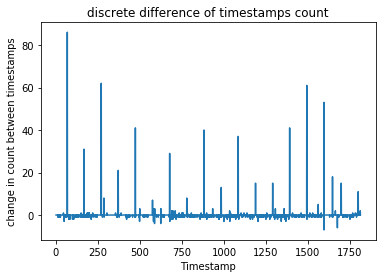

In [245]:
timestamp = df['timestamp'].values
timediff = df.groupby('timestamp')['timestamp'].count().diff()
plt.plot(timediff)
plt.xlabel('Timestamp')
plt.ylabel('change in count between timestamps')
plt.title('discrete difference of timestamps count')

In [248]:
timediff[abs(timediff)>15]

timestamp
68      86.0
167     31.0
270     62.0
371     21.0
473     41.0
677     29.0
881     40.0
1085    37.0
1391    41.0
1493    61.0
1595    53.0
1646    18.0
Name: timestamp, dtype: float64

We can notice that the timestamp difference has a peak at approximately every 100 timestamps, with some gaps greater or less than 100, which indicate that 100 timestamps could be a meaningful period in time.


In [249]:
len(df['timestamp'].unique())/100

18.13

Number of total timestamp divided by 100 gives 18.13, which could mean how many months or seasons the data contains. 

In [10]:
# This will print the dataset
df.head()

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,...,technical_43,technical_44,y,y_lagged,technical_diff,krnldiff,delta5diff,krnl40,delta540,fmod29
0,10,0,0.370326,-0.006316,0.222831,-0.213030,0.729277,-0.335633,0.113292,1.621238,...,-2.0,0.000951,-0.011753,0.000046,0.000000,0.0,0.0,-0.041838,0.000011,0.666596
1,11,0,0.014765,-0.038064,-0.017425,0.320652,-0.034134,0.004413,0.114285,-0.210185,...,-2.0,0.000951,-0.001240,0.000046,0.000000,0.0,0.0,-0.041838,0.000011,0.666596
2,12,0,-0.010622,-0.050577,1.571245,-0.157525,-0.068550,-0.155937,1.060683,-0.764516,...,-2.0,0.000951,-0.020940,0.000046,0.006942,0.0,0.0,-0.041838,0.000011,0.666596
3,25,0,-0.003429,-0.012705,-0.005859,-0.037375,0.024913,0.178495,0.044287,-0.007262,...,-2.0,0.000951,-0.015959,0.000046,0.006766,0.0,0.0,-0.041838,0.000011,0.666596
4,26,0,0.176693,-0.025284,-0.057680,0.015100,0.180894,0.139445,-0.125687,-0.018707,...,0.0,0.000951,-0.007338,0.000046,0.006236,0.0,0.0,-0.041838,0.000011,0.666596


If the original data is stored, the data preparation code will be executed in the following cell. First, extreme values in each feature set are removed. Then, some hand-crafted features are added to feature set to boost the prediction accuracy. There are many methods including PCA and auto-encoders to do the feature engineering rather than creating hand-crafted features. As an exercise, we highly recommend you to add auto-encoders to the code and check the accuracy after the lab. Lastly, NaNs are replaced with the median of the feature.


---------

#TODO start new notebook
# Trading Strategy for Finance using LSTMs

#### Model Construction

Now, we set up the TensorFlow compute graph. The deep neural network that is used in this code is comprised of a LSTM cell that runs over 10 time steps, a fully connected layers (FCL), and also drop-out layers to prevent overfitting. Calculating the number of time steps for a recurrent neural network is not a trivial task. It is actually another hyperparameter that needs to be searched. The network is depicted in the following figure.

<img src="../imgs/dnn.jpg" width="700" height="700">

        Figure 3: Structure of the LSTM based deep neural network
                                
Below is the code to build the deep neural network depicted in Figure 3;

In [295]:
def weight_variable(shape): 
    initial = tf.truncated_normal(shape, stddev=0.3)
    return tf.Variable(initial) 
    
def bias_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.3)
    return tf.Variable(initial) 

n_time_steps = 10
def getDNN (x, LSTMCellSize, keep_prob):
    with tf.name_scope('model'):
        with tf.name_scope('RNN'):
            # We will add two dropout layers and LSTM cells with the number of units as LSTMCellSize.
            cell = rnn.DropoutWrapper(rnn.BasicLSTMCell(LSTMCellSize, forget_bias=2, activation=tf.nn.tanh), output_keep_prob=keep_prob)
            # We use the cell to create RNN.
#             Note that outputs is not a tensor, it is a list with one element which is numpy array.
####### Modify deprecated function ###########
            outputs, states = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32) 
#             outputs, states = keras.layers.RNN(cell, x, dtype=tf.float32) 
            outputs_shape = outputs.get_shape().as_list()
                
        # hidden layer with sigmoid activation
        with tf.name_scope('W_fc1'):
            W_fc1 = weight_variable([LSTMCellSize, 1])
        with tf.name_scope('b_fc1'):
            b_fc1 = bias_variable([1])
        with tf.name_scope('pred'):
            pred = tf.matmul(outputs[:,-1,:], W_fc1) + b_fc1

        return pred
    


In [296]:
# The column names that will be included in the featureset are added into colList.
# colList will be used throughout the lab.
colList=[]                  
for thisColumn in df.columns: 
    if thisColumn not in ('id', 'timestamp', 'y', 'CntNs', 'y_lagged'): 
        colList.append(thisColumn)
colList.append('y_lagged')

#if you do not reset the default graph you will need to restart the kernel
#every time this notebook is run
tf.reset_default_graph()

# Network Parameters 
# Number of units in the LSTM cell.
n_LSTMCell = len(colList)

# Placeholder for the input and the keep probability for the dropout layers
with tf.name_scope('input'):
    x= tf.placeholder(tf.float32, shape=[None, n_time_steps, len(colList)])
with tf.name_scope('keep_prob'):
    keep_prob = tf.placeholder(tf.float32)

# At the input, we create 2-layer LSTM cell (with dropout layers)
print('Building tensorflow graph')

# Graph construction for the LSTM based deep neural network. 
# Structure of the network is depicted in the above figure.
# Please see the dnn.py to see the code of the network.
pred = getDNN (x, n_LSTMCell, keep_prob)

Building tensorflow graph


#### Training and Testing

We split the data into two pieces in time to have a training and testing set. In order to have enough sample for each id, the cut-off timestamp for the training set was defined in "insampleCutoffTimestamp" variable as 1650. Figure 4 shows how an instrument is split in time to create training and testing set. While training the model, the training set for each instrument will be fed separately to learn the time patterns in the data.

<img src="../imgs/data_split.jpg" width="600" height="600">

                    Figure 4: Training and Testing Dataset
    
In the Kaggle challenge, the metric to evaluate the prediction accuracy was given as Pearson correlation. In statistics, [pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) is a measure of the linear correlation between two variables X and Y. It has a value between +1 and −1, where 1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation. It is widely used in the sciences. It was developed by Karl Pearson from a related idea introduced by Francis Galton in the 1880s.

Depending on the frequency of the financial data, Pearson correlation (R) can be very small. In finance, given the high ratio of signal-to-noise, even a small R can deliver meaningful value. Please note that the algorithm that won the challenge had only 0.038 R.

The following cell includes the code for creating training and testing set, and calculating Pearson correlation.

In [297]:
# Placeholder for the output (label)
with tf.name_scope('label'):
    y = tf.placeholder(tf.float32, shape=[None, 1]) 
# Placeholder to be able to split the data into training and test set while training the network.
inSampleCutoff = tf.placeholder(tf.int32, shape = ())

# this is important - we only want to train on the in-sample set of rows using TensorFlow
y_inSample = y[0:inSampleCutoff]
pred_inSample = pred[0:inSampleCutoff]

# also extract out of sample predictions and actual values,
# we'll use them for evaluation while training the model.
y_outOfSample = y[inSampleCutoff:]
pred_outOfSample = pred[inSampleCutoff:]

with tf.name_scope('stats'):
    # Pearson correlation to evaluate the model
    covariance = tf.reduce_sum(tf.matmul(tf.transpose(tf.subtract(pred_inSample, tf.reduce_mean(pred_inSample))),tf.subtract(y_inSample, tf.reduce_mean(y_inSample))))
    var_pred = tf.reduce_sum(tf.square(tf.subtract(pred_inSample, tf.reduce_mean(pred_inSample))))
    var_y = tf.reduce_sum(tf.square(tf.subtract(y_inSample, tf.reduce_mean(y_inSample))))
    pearson_corr = covariance / tf.sqrt(var_pred * var_y) 

tf.summary.scalar("pearson_corr", pearson_corr)

<tf.Tensor 'pearson_corr:0' shape=() dtype=string>

In most of the traditional machine learning and deep learning methods, it is assumed that the feature set and predicted value have zero mean and unit variance gaussian distribution. Empirical studies show that the financial data such as asset returns is often not compatible with this assumption. That is why we normalize the "y" variable by subtracting its mean and dividing the result by the standard deviation in the following cell. As an exercise, you can also normalize the features and see if you improve the accuracy.

In [298]:
# Training dataset is also created here. We included the code to split the data in the above cell. 
# The difference is that the above code will be used in the training by the TensorFlow.
# This code will not be used by TensorFlow and creates the testing dataset whenever it is executed.
dfInSample = df[df.timestamp <  insampleCutoffTimestamp]
# create a reference dataframe (that only depends on in-sample data)
# that gives us standard deviation and mean information on per-id basis
# we'll use it later for variance stabilization
meanStdById = dfInSample.groupby(['id']).agg( {'y':['mean', 'std']})

We are ready to launch the graph for training the model and see intermediate diagnostics results and the final result. We defined the important hyperparameters including the epoch, training batch size and learning rate at the top of the cell. Initially, the epoch is set to 1 because it takes 15-20 minutes to complete the training with 10 epochs even though we are using GPUs. In order to speed up the training in the lab environment, we provided pre-trained networks with 10 epochs and 20 epochs. An adaptive learning rate starting from 0.002 with exponential decay is used for the training from scratch. Learning rate should be set to 0.00058 and 0.00061 for using pre-trained models with 10 and 15 epochs respectively.

In [ ]:
# Training parameters
display_step = 100 
epoch = 100
# pre_trained_model = '../tasks/model2.ckpt'
mini_batch_limit = 1300

# set up adaptive learning rate:
globalStep = tf.placeholder(tf.float32)
# Ratio of globalStep / totalDecaySteps is designed to indicate how far we've progressed in training.
# the ratio is 0 at the beginning of training and is 1 at the end.
# adaptiveLearningRate will thus change from the starting learningRate to learningRate * decay_rate
# in order to simplify the code, we are fixing the total number of decay steps at 1 and pass globalStep
# as a fraction that starts with 0 and tends to 1.
# Learning rate should be set to 0.002 if you are training from scratch.
# Learning rate should be set to 0.00058 if you are using the pre-trained network with 10 epochs.
# Learning rate should be set to 0.00061 if you are using the pre-trained network with 15 epochs.
adaptiveLearningRate = tf.train.exponential_decay(
  0.00058,       # Start with this learning rate
  globalStep,  # globalStep / totalDecaySteps shows how far we've progressed in training
  1,           # totalDecaySteps
  0.3)         # decay_rate, the factor by which the starting learning rate will be 
               # multiplied when the training is finished
    
# Define loss and optimizer
# Note the loss only involves in-sample rows
# Regularization is added in the loss function to avoid over-fitting
rnn_variables = lstm_variables = [v for v in tf.trainable_variables()
                    if v.name.startswith('rnn')]

with tf.name_scope('loss'):
    loss = tf.nn.l2_loss(tf.subtract(y_inSample,pred_inSample)) + tf.contrib.layers.apply_regularization(tf.contrib.layers.l2_regularizer(scale=0.0001), tf.trainable_variables())
tf.summary.scalar("loss", loss)
optimizer = tf.train.AdamOptimizer(learning_rate=adaptiveLearningRate).minimize (loss) 

# Getting unique ids to train the network per id basis.
ids = df.id.unique()
ids.sort()

summary_op = tf.summary.merge_all()

# initialize the variables 
init = tf.global_variables_initializer()

totalActual = []
totalPredicted = []
import random
# Launch the graph 
# Implement Cross Validation, but in a vay that preserves temporal structure for id's 
with tf.Session() as sess:  
    # Global variables are initialized
    sess.run(init) 
    
    # Restore latest checkpoint
#     model_saver = tf.train.Saver()
#     model_saver.restore(sess, pre_trained_model)
    
    writer = tf.summary.FileWriter("/home/marketlab/Documents/tensorboard.log", graph=tf.get_default_graph())
    step = 50  
    writer_step = 1;
    for i in range(epoch):
        print('Epoch: ', i, '******************************')        
        actual = []
        predicted = []
        
        random.shuffle(ids)

        for thisId in ids:
            # Getting the data of the current id
            this_df = df[df.id == thisId].copy()
            this_df = this_df.sort_values(['id', 'timestamp'])
                        
            # we need to pass training set to the graph definition
            # optimization will only consider in training set
            inSampleSize, _ = this_df[this_df.timestamp < insampleCutoffTimestamp].shape
            totalRows, _ = this_df.shape
            
            batch_y = this_df.loc[:,'y'].values            
            batch_x = this_df[colList].values
                    
            if totalRows < n_time_steps:
                continue

            # Data is formated as a 3D tensor with the shape of (batch_size, n_time, n_feature) for LSTM
            # n_time_steps parameter determines how many steps that LSTM will unroll in time
            complete_x = np.zeros([totalRows-n_time_steps+1, n_time_steps, len(colList)])
            for n in range(n_time_steps):
                complete_x[:,n,:]=batch_x[n:totalRows-n_time_steps+n+1,:]
            
            batch_y = batch_y[n_time_steps-1:]
            inSampleSize -= n_time_steps - 1

            # variance stabilizing transform
            # some id's will not have in-sample rows, we cannot perform transform on those
            # furthermore, since there is not in-sample rows to train on, we must skip
            if inSampleSize < 10:
                continue
                
            # perform variance stabilization
            thisMean = meanStdById.loc[thisId][0]
            thisStd = meanStdById.loc[thisId][1]
            batch_y = (batch_y - thisMean) / thisStd
            
            batch_y = batch_y.reshape(-1,1)
            minibatchSize, _ = batch_y.shape

            # we want to make sure that RNN reaches steady state
            if minibatchSize < mini_batch_limit: 
                continue 
            
            # Run optimization 
            # note: keep_prob is set to 0.5 for training only!
            _, currentRate = sess.run([optimizer, adaptiveLearningRate], feed_dict={x: complete_x, y: batch_y, keep_prob:0.5, inSampleCutoff:inSampleSize, globalStep:i/epoch})

            # Obtain out of sample target variable and our prediction
            y_oos, pred_oos = sess.run([y_outOfSample, pred_outOfSample], feed_dict={x: complete_x, y: batch_y, keep_prob:1.0, inSampleCutoff:inSampleSize}) 
            
            # flatten the returned lists
            y_oos = [y for x in y_oos for y in x]
            pred_oos = [y for x in pred_oos for y in x]
            
            #reverse transform before recording the results
            if inSampleSize:            
                y_oos = [ (t*thisStd + thisMean) for t in y_oos]
                pred_oos = [ (t*thisStd + thisMean) for t in pred_oos]
            
            # record the results
            actual.extend(y_oos)
            predicted.extend(pred_oos)
                       
            totalActual.extend(y_oos)
            totalPredicted.extend(pred_oos)
            
            # Once every display_step show some diagnostics - the loss function, in-sample correlation, etc.
            if step % display_step == 0: 
                # Calculate batch accuracy 
                # Calculate batch loss 
                correl, lossResult, summary = sess.run([pearson_corr, loss, summary_op], feed_dict={x: complete_x, y: batch_y, keep_prob:1.0, inSampleCutoff:inSampleSize})
                
                writer.add_summary(summary, writer_step)
                writer_step += 1
                # corrcoef sometimes fails to compute correlation for a perfectly valid reason (e.g. stdev(pred_oos) is 0)
                # it sets the result to nan, but also gives an annoying warning
                # the following suppresses the warning
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    correl_oos = np.corrcoef(y_oos, pred_oos)[0,1]
                    
                print('LR: %s - Iter %s, minibatch loss = %s, minibatch corr = %s, oos %s (%s/%s)' % (currentRate, step, lossResult, correl, correl_oos, inSampleSize, totalRows))
                
            step += 1 
       
        print('Optimization Finished!') 
        print('Correl: ', np.corrcoef(actual, predicted)[0,1])
        model_saver = tf.train.Saver()
        save_path = model_saver.save(sess, "../tasks/model2.ckpt")
        print("Model saved in path: %s" % save_path)

Epoch:  0 ******************************
LR: 0.00058 - Iter 100, minibatch loss = 962.4227, minibatch corr = 0.023755517, oos -0.07381570881857133 (1641/1813)
LR: 0.00058 - Iter 200, minibatch loss = 837.3868, minibatch corr = 0.009716592, oos -0.13011421425207764 (1641/1813)


It takes 3-5 minutes to complete the training with 1 epochs. We also provided TensorBoard to review the model architecture, loss and correlation variables. TensorBoard is a suite of web applications for inspecting and understanding your TensorFlow runs and graphs. 

### Click [here](http://128.174.40.25:6007/#scalars) to start TensorBoard.

You should get a correlation value around R = 0.04. Note that the correlation tends to increase with each epoch (but not always). 

Since training takes significant amount of time, we recommend you train the model with 20 epochs and check the correlation after this lab in your environment. You should get a correlation value around R = 0.05.


# Trading Strategy for Finance using LSTMs

## Optional Exercise
Please read ahead and only come back to these optional exercises if time permits.

**Train from scratch** [20-30 mins]

First, change the # of epochs to 20 in the above cell. Second, put the starting learning rate back to **0.002**. Third, comment out the two line where the pre-trained model is loaded (under "Restore latest checkpoint"). Then re-run everything using Kernel->Restart & Run All. 



#### How can a portfolio manager assess the predicted signal?

We could scatter-plot actual returns over the predicted returns, however correlation is not visually apparent on scatter plots when the correlation is below 20-30%. The correlation we achieve in this signal is much weaker which is typical of modern financial markets. Correlations which we often observe in other applications of predictive models are all but impossible in the financial markets which are highly efficient (simply put, unpredictable). If we imagine that someone has a signal with correlation of 30% using leverage the person would soon get extremely rich - and the observed signal (inefficiency) would disappear from the market.

In order to visually assess the signal, we split out of sample data points into buckets based on the value of predicted returns. We then compute per-bucket mean actual returns. Then we plot mean actual returns (Y axis) against predicted returns (X axis). We thus plot one point per bucket. By taking mean value, we average out the variance within each bucket and uncover the predictive value of the signal.

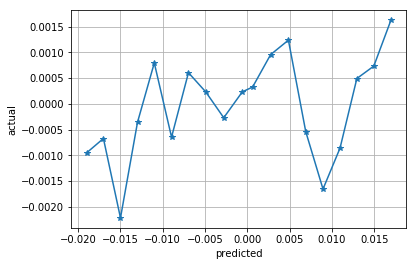

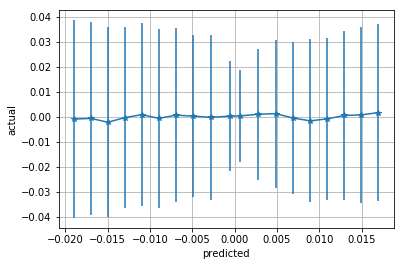

In [268]:
actual = totalActual
predicted = totalPredicted

actualMeanReturn = []
predictedMeanReturn = []
stdActualReturns = []
# Buckets are created
buckets = np.arange(-0.02,0.02,0.002)

actual = np.array(actual)
predicted = np.array(predicted)

# Predicted values and the actual values are placed into buckets
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(len(buckets)-1):
        index = np.logical_and(predicted>buckets[i], predicted<buckets[i+1])
        thisBucket = actual[index].mean()
        actualMeanReturn.append(thisBucket)
        predictedMeanReturn.append(predicted[index].mean())
        stdActualReturns.append(actual[index].std())

# Actual versus predicted values are plotted
plt.figure()
plt.plot(predictedMeanReturn,actualMeanReturn, marker='*')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.grid(True)
plt.show()

plt.figure()
plt.errorbar(predictedMeanReturn, actualMeanReturn, yerr = stdActualReturns, marker='*')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.grid(True)
plt.show()


**How much variance is there?**

Plot 2 answers this question by adding error bars to the previous plot. Length of the error bar is equal to the standard deviation of actual returns within each respective bucket.
Plots such as these would be typically used by a portfolio manager to assess behavior of prospective signals and to assess signal levels at which an action should be taken. The simplest trading system utilizing this signal would buy security when predicted return is above some threshold (say, above 0.5%) and sell (or short-sell) the security when the signal is below negative threshold (e.g. below -0.5%). 


NameError: name 'numpy' is not defined